In [36]:
# !conda create --name steffen-voxelmorph-python3.7_tf2.4.1 python=3.7 tensorflow-gpu=2.4.1
# !pip install voxelmorph  # for all things voxelmorph/neurite
# !pip install tensorflow_addons  # for tqdm callbacks

# some imports we'll need throughout the demo
import os

# some third party very useful libraries
import tensorflow as tf
import tensorflow_addons as tfa  # for TQDM callback
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm
import nibabel as nib

# our libraries
import voxelmorph as vxm
import neurite as ne

# turn off eager for this
# need to do it due to some tf 2.0+ compatibility issues
tf.compat.v1.disable_eager_execution()

# some helpful functions
def plot_hist(hist):
  plt.figure(figsize=(17,5))
  plt.subplot(1, 2, 1)
  plt.plot(hist.epoch, hist.history['loss'], '.-')
  plt.ylabel('loss')
  plt.xlabel('epochs');
  plt.subplot(1, 2, 2)
  nb_epochs = len(hist.epoch) // 2
  plt.plot(hist.epoch[-nb_epochs:], hist.history['loss'][-nb_epochs:], '.-')
  plt.ylabel('loss')
  plt.xlabel('epochs');
  plt.show()


# generally useful callback
# unfortunately show_epoch_progress=True leaves a printout that we can't control (bad implementation in tfa...)
tqdm_cb = tfa.callbacks.TQDMProgressBar(leave_epoch_progress=False, show_epoch_progress=False) 

In [37]:
# prepare data
# !ln -s /mnt/FileSystem-DeepLearning/vnm/qsm28_data/realigned_bias-corrected_skullstripped_rescaled-0-1 ourdata
files = ['ourdata/' + f for f in os.listdir('ourdata') if f.endswith('mn_skull_stripped_rescaled-0-1.nii.gz')]
vols = [nib.load(f).get_fdata() for f in tqdm(files)]

  0%|          | 0/29 [00:00<?, ?it/s]

In [57]:
x_vols_full = np.expand_dims(np.stack(vols, 0), -1)
print('x_vols_full.shape: ', x_vols_full.shape)
x_vols = x_vols_full[:,0:160,0:160,0:160]
print('x_vols.shape: ', x_vols.shape)
vol_shape = x_vols.shape[1:-1]

x_vols_full.shape:  (29, 197, 233, 189, 1)
x_vols.shape:  (29, 160, 160, 160, 1)


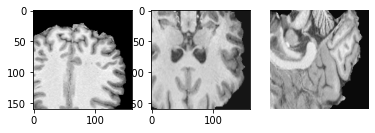

In [59]:
# visualize input data
plt.subplot(1, 3, 1)
plt.imshow(np.rot90(x_vols[2,:,:,100], -1), cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(np.rot90(x_vols[2,:,100,:], -1), cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(np.rot90(x_vols[2,100,:,:], -1), cmap='gray')
plt.axis('off');

In [60]:
# get the model
enc_nf = [16, 32, 32, 32]
dec_nf = [32, 32, 32, 32, 32, 16, 16]
model = vxm.networks.TemplateCreation(vol_shape, nb_unet_features=[enc_nf, dec_nf])

LocalParamWithInput: Consider using neuron.layers.LocalParam()


In [ ]:
# prepare a simple generator. 
def template_gen(x, batch_size):
  vol_shape = list(x.shape[1:-1])
  zero = np.zeros([batch_size] + vol_shape + [3])
  mean_atlas = np.repeat(  np.mean(x, 0, keepdims=True), batch_size, 0)

  while True:
    idx = np.random.randint(0, x.shape[0], batch_size)
    img = x[idx, ...]
    inputs = [mean_atlas, img]
    outputs = [img, zero, zero, zero]
    yield inputs, outputs


In [ ]:
# let's make sure the sizes make sense
sample = next(template_gen(x_vols, 8))
[print(f.shape) for f in sample[0]], [print(f.shape) for f in sample[1]]

enc_nf = [16, 32, 32, 32]
dec_nf = [32, 32, 32, 32, 32, 16, 16]

print(vol_shape)

(8, 160, 192, 160, 1)
(8, 160, 192, 160, 1)
(8, 160, 192, 160, 1)
(8, 160, 192, 160, 3)
(8, 160, 192, 160, 3)
(8, 160, 192, 160, 3)
(160, 192, 160)


In [ ]:
# creat model
model = vxm.networks.TemplateCreation(vol_shape, nb_unet_features=[enc_nf, dec_nf])


LocalParamWithInput: Consider using neuron.layers.LocalParam()


In [ ]:
# prepare losses
image_loss_func = vxm.losses.MSE().loss
neg_loss_func = lambda _, y_pred: image_loss_func(model.references.atlas_tensor, y_pred)
losses = [image_loss_func, neg_loss_func, vxm.losses.MSE().loss, vxm.losses.Grad('l2', loss_mult=2).loss]
loss_weights = [0.5, 0.5, 1, 0.01]

model.compile('adam', loss=losses, loss_weights=loss_weights)

In [ ]:
# The GPU id to use, either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="1";  

In [ ]:
# train
gen = template_gen(x_vols, batch_size=1)
hist = model.fit(gen, epochs=1, steps_per_epoch=1, verbose=0, callbacks=[tqdm_cb])

Training:   0%|           0/1 ETA: ?s,  ?epochs/s

ResourceExhaustedError: OOM when allocating tensor of shape [160,192,160,3] and type float
	 [[node mean_stream_4/mean/Initializer/zeros (defined at /home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/neurite/tf/layers.py:1522) , node mean_stream_5/mean/Initializer/zeros (defined at /home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/neurite/tf/layers.py:1522) ]]

Original stack trace for 'mean_stream_4/mean/Initializer/zeros':
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/traitlets/config/application.py", line 845, in launch_instance
    app.start()
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 612, in start
    self.io_loop.start()
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
    self._run_once()
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/asyncio/base_events.py", line 1786, in _run_once
    handle._run()
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/tornado/ioloop.py", line 688, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/tornado/ioloop.py", line 741, in _run_callback
    ret = callback()
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/tornado/gen.py", line 814, in inner
    self.ctx_run(self.run)
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/tornado/gen.py", line 775, in run
    yielded = self.gen.send(value)
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/tornado/gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/tornado/gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 545, in execute_request
    user_expressions, allow_stdin,
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/tornado/gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 306, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2895, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2940, in _run_cell
    return runner(coro)
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3166, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3357, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-50-49308819c479>", line 4, in <module>
    model = vxm.networks.TemplateCreation(vol_shape, nb_unet_features=[enc_nf, dec_nf])
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/voxelmorph/tf/modelio.py", line 22, in wrapper
    retval = func(self, *args, **kwargs)
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/voxelmorph/tf/networks.py", line 578, in __init__
    mean_stream = ne.layers.MeanStream(name='mean_stream', cap=mean_cap)(neg_flow)
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer_v1.py", line 766, in __call__
    self._maybe_build(inputs)
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer_v1.py", line 2106, in _maybe_build
    self.build(input_shapes)
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/neurite/tf/layers.py", line 1522, in build
    trainable=False)
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer_v1.py", line 457, in add_weight
    caching_device=caching_device)
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/tensorflow/python/training/tracking/base.py", line 810, in _add_variable_with_custom_getter
    **kwargs_for_getter)
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer_utils.py", line 142, in make_variable
    shape=variable_shape if variable_shape else None)
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/tensorflow/python/ops/variables.py", line 260, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/tensorflow/python/ops/variables.py", line 221, in _variable_v1_call
    shape=shape)
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/tensorflow/python/ops/variables.py", line 199, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/tensorflow/python/ops/variable_scope.py", line 2618, in default_variable_creator
    shape=shape)
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/tensorflow/python/ops/variables.py", line 264, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/tensorflow/python/ops/resource_variable_ops.py", line 1585, in __init__
    distribute_strategy=distribute_strategy)
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/tensorflow/python/ops/resource_variable_ops.py", line 1712, in _init_from_args
    initial_value = initial_value()
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/tensorflow/python/keras/initializers/initializers_v2.py", line 139, in __call__
    return super(Zeros, self).__call__(shape, dtype=_get_dtype(dtype), **kwargs)
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/tensorflow/python/ops/init_ops_v2.py", line 154, in __call__
    return array_ops.zeros(shape, dtype)
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py", line 201, in wrapper
    return target(*args, **kwargs)
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py", line 2819, in wrapped
    tensor = fun(*args, **kwargs)
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py", line 2880, in zeros
    output = fill(shape, constant(zero, dtype=dtype), name=name)
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py", line 201, in wrapper
    return target(*args, **kwargs)
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py", line 239, in fill
    result = gen_array_ops.fill(dims, value, name=name)
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3358, in fill
    "Fill", dims=dims, value=value, name=name)
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py", line 750, in _apply_op_helper
    attrs=attr_protos, op_def=op_def)
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 3536, in _create_op_internal
    op_def=op_def)
  File "/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 1990, in __init__
    self._traceback = tf_stack.extract_stack()


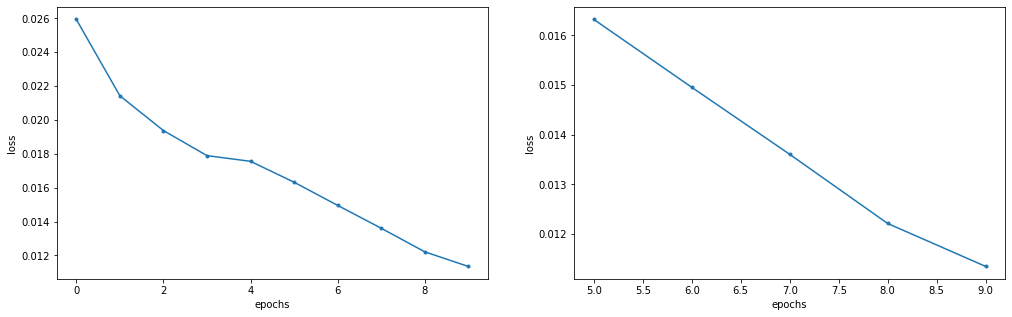

In [ ]:
# visualize optimization
plot_hist(hist)

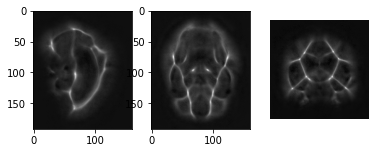

In [ ]:
atlas = model.references.atlas_layer.get_weights()[0][..., 0]
plt.subplot(1, 3, 1)
plt.imshow(np.rot90(atlas[100,:,:], -1), cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(np.rot90(atlas[:,100,:], -1), cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(np.rot90(atlas[:,:,100], -1), cmap='gray')
plt.axis('off');
plt.axis('off');